In [1]:
pip install nixtla

Note: you may need to restart the kernel to use updated packages.


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

In [22]:
from nixtla import NixtlaClient

nixtla_client = NixtlaClient(api_key = 'nixak-2kWHYT0enCFZc2asqSf3T84UgOZI24uEPcy3qPnEdryifVfk8J6ZSkYaM2pBej3qMRkxGqytb2U2SYBP')

In [23]:
df = pd.read_csv('Stocksastra.csv')
df

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah
0,2022-07-01,6.525,6.675,6.675,6.500
1,2022-07-04,6.500,6.500,6.575,6.300
2,2022-07-05,6.325,6.500,6.525,6.325
3,2022-07-06,6.075,6.300,6.400,6.050
4,2022-07-07,5.950,6.025,6.125,5.900
...,...,...,...,...,...
620,2025-01-22,4.960,4.920,4.980,4.880
621,2025-01-23,4.900,4.960,4.980,4.900
622,2025-01-24,4.870,4.900,4.960,4.870
623,2025-01-30,4.780,4.870,4.870,4.780


In [24]:
print(df.isnull().sum())


Tanggal      0
Terakhir     0
Pembukaan    0
Tertinggi    0
Terendah     0
dtype: int64


In [25]:
print(df.isnull().values.any())


False


In [26]:
print(df[df.isnull().any(axis=1)])


Empty DataFrame
Columns: [Tanggal, Terakhir, Pembukaan, Tertinggi, Terendah]
Index: []


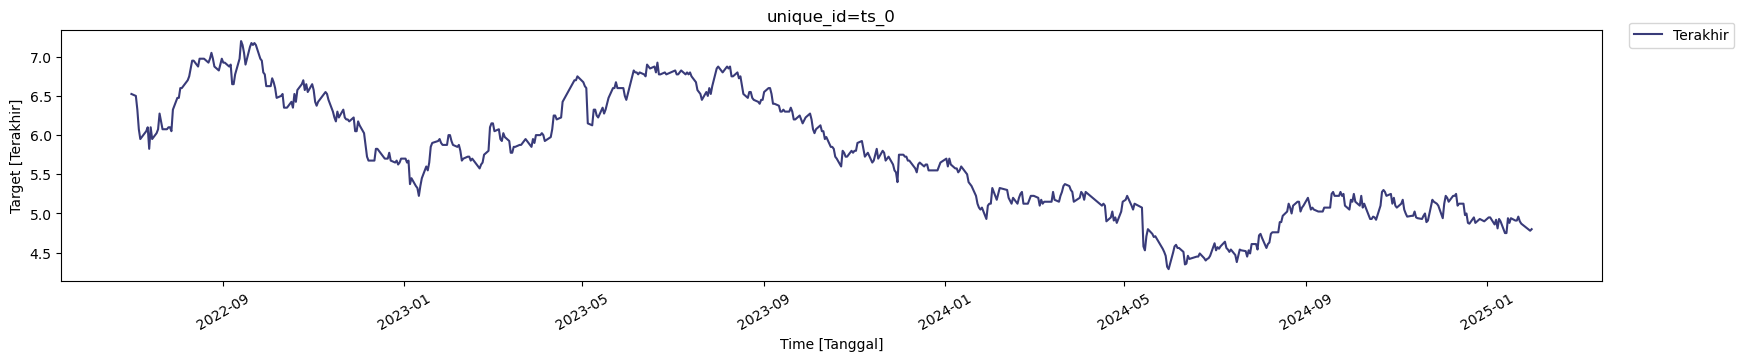

In [14]:
nixtla_client.plot(df, time_col='Tanggal', target_col='Terakhir')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


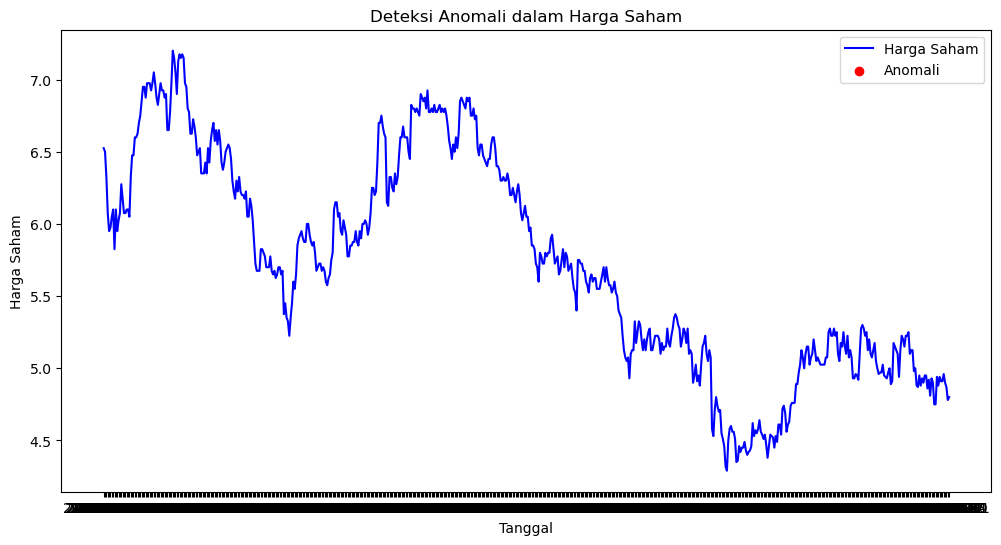

In [15]:
import numpy as np

Q1 = df['Terakhir'].quantile(0.25)
Q3 = df['Terakhir'].quantile(0.75)
IQR = Q3 - Q1

# Aturan untuk mendeteksi outlier
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Menandai outlier
df['Anomaly'] = (df['Terakhir'] < lower_bound) | (df['Terakhir'] > upper_bound)

# Visualisasi
plt.figure(figsize=(12, 6))
plt.plot(df['Tanggal'], df['Terakhir'], label='Harga Saham', color='blue')
plt.scatter(df[df['Anomaly']]['Tanggal'], df[df['Anomaly']]['Terakhir'], color='red', label='Anomali')
plt.xlabel('Tanggal')
plt.ylabel('Harga Saham')
plt.title('Deteksi Anomali dalam Harga Saham')
plt.legend()
plt.show()


In [27]:
df['Tanggal'] = pd.to_datetime(df['Tanggal'])
df = df.sort_values('Tanggal')
df = df.rename(columns={'Tanggal': 'ds'})  # TimeGPT pakai 'ds'

# Daftar kolom target
target_columns = ['Terakhir', 'Pembukaan', 'Tertinggi', 'Terendah']

In [28]:
# Reindex ke frekuensi bisnis ('B' = Business days)
df.set_index('ds', inplace=True)
df = df.asfreq('B')  

df = df.interpolate(method='linear')

# Reset index untuk TimeGPT
df = df.reset_index()


In [30]:
# Setup prediksi
start_date = pd.to_datetime('2024-07-01')
end_date = pd.to_datetime('2025-01-31')
horizon = 7  # prediksi 7 hari ke depan

# DataFrame hasil
results = []

# Prediksi per kolom target
for target_col in target_columns:
    print(f"Memulai prediksi untuk kolom: {target_col}")
    current_date = start_date
    df_target = df[['ds', target_col]].dropna().rename(columns={target_col: 'y'})
    
    df_target['y'] = np.log(df_target['y'])  # Transformasi log agar stabil

    while current_date <= end_date:
        train_data = df_target[df_target['ds'] < current_date]
        
        if train_data.empty:
            print(f"Tidak ada data sebelum {current_date} untuk {target_col}")
            break

        try:
            forecast = nixtla_client.forecast(
                df=train_data,
                h=horizon,
                freq='B',
                time_col='ds',
                target_col='y',
                model='timegpt-1',
                finetune_steps=1,
                finetune_depth=1,
                finetune_loss="mae"
            )

            pred_dates = pd.date_range(start=current_date, periods=horizon, freq='B')
            y_preds = np.exp(forecast['TimeGPT'].values)  # balik log
            
            result_df = pd.DataFrame({'ds': pred_dates, 'y': y_preds})
            result_df['kolom'] = target_col
            results.append(result_df)

            print(f"✅ Berhasil prediksi {target_col} untuk {current_date.date()} sampai {pred_dates[-1].date()}")

        except Exception as e:
            print(f"❌ Gagal prediksi {target_col} untuk {current_date.date()}: {e}")
            break

        current_date += pd.Timedelta(days=horizon)

# Gabungkan semua hasil
final_result = pd.concat(results, ignore_index=True)
final_result.to_csv('forecast_stocksastra_multi_target.csv', index=False)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...


Memulai prediksi untuk kolom: Terakhir


INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terakhir untuk 2024-07-01 sampai 2024-07-09


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terakhir untuk 2024-07-08 sampai 2024-07-16


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terakhir untuk 2024-07-15 sampai 2024-07-23


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terakhir untuk 2024-07-22 sampai 2024-07-30


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terakhir untuk 2024-07-29 sampai 2024-08-06


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terakhir untuk 2024-08-05 sampai 2024-08-13


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terakhir untuk 2024-08-12 sampai 2024-08-20


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terakhir untuk 2024-08-19 sampai 2024-08-27


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terakhir untuk 2024-08-26 sampai 2024-09-03


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terakhir untuk 2024-09-02 sampai 2024-09-10


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terakhir untuk 2024-09-09 sampai 2024-09-17


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terakhir untuk 2024-09-16 sampai 2024-09-24


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terakhir untuk 2024-09-23 sampai 2024-10-01


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terakhir untuk 2024-09-30 sampai 2024-10-08


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terakhir untuk 2024-10-07 sampai 2024-10-15


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terakhir untuk 2024-10-14 sampai 2024-10-22


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terakhir untuk 2024-10-21 sampai 2024-10-29


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terakhir untuk 2024-10-28 sampai 2024-11-05


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terakhir untuk 2024-11-04 sampai 2024-11-12


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terakhir untuk 2024-11-11 sampai 2024-11-19


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terakhir untuk 2024-11-18 sampai 2024-11-26


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terakhir untuk 2024-11-25 sampai 2024-12-03


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terakhir untuk 2024-12-02 sampai 2024-12-10


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terakhir untuk 2024-12-09 sampai 2024-12-17


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terakhir untuk 2024-12-16 sampai 2024-12-24


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terakhir untuk 2024-12-23 sampai 2024-12-31


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terakhir untuk 2024-12-30 sampai 2025-01-07


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terakhir untuk 2025-01-06 sampai 2025-01-14


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terakhir untuk 2025-01-13 sampai 2025-01-21


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terakhir untuk 2025-01-20 sampai 2025-01-28


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terakhir untuk 2025-01-27 sampai 2025-02-04
Memulai prediksi untuk kolom: Pembukaan


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Pembukaan untuk 2024-07-01 sampai 2024-07-09


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Pembukaan untuk 2024-07-08 sampai 2024-07-16


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Pembukaan untuk 2024-07-15 sampai 2024-07-23


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Pembukaan untuk 2024-07-22 sampai 2024-07-30


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Pembukaan untuk 2024-07-29 sampai 2024-08-06


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Pembukaan untuk 2024-08-05 sampai 2024-08-13


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Pembukaan untuk 2024-08-12 sampai 2024-08-20


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Pembukaan untuk 2024-08-19 sampai 2024-08-27


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Pembukaan untuk 2024-08-26 sampai 2024-09-03


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Pembukaan untuk 2024-09-02 sampai 2024-09-10


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Pembukaan untuk 2024-09-09 sampai 2024-09-17


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Pembukaan untuk 2024-09-16 sampai 2024-09-24


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Pembukaan untuk 2024-09-23 sampai 2024-10-01


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Pembukaan untuk 2024-09-30 sampai 2024-10-08


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Pembukaan untuk 2024-10-07 sampai 2024-10-15


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Pembukaan untuk 2024-10-14 sampai 2024-10-22


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Pembukaan untuk 2024-10-21 sampai 2024-10-29


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Pembukaan untuk 2024-10-28 sampai 2024-11-05


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Pembukaan untuk 2024-11-04 sampai 2024-11-12


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Pembukaan untuk 2024-11-11 sampai 2024-11-19


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Pembukaan untuk 2024-11-18 sampai 2024-11-26


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Pembukaan untuk 2024-11-25 sampai 2024-12-03


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Pembukaan untuk 2024-12-02 sampai 2024-12-10


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Pembukaan untuk 2024-12-09 sampai 2024-12-17


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Pembukaan untuk 2024-12-16 sampai 2024-12-24


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Pembukaan untuk 2024-12-23 sampai 2024-12-31


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Pembukaan untuk 2024-12-30 sampai 2025-01-07


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Pembukaan untuk 2025-01-06 sampai 2025-01-14


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Pembukaan untuk 2025-01-13 sampai 2025-01-21


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Pembukaan untuk 2025-01-20 sampai 2025-01-28


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Pembukaan untuk 2025-01-27 sampai 2025-02-04
Memulai prediksi untuk kolom: Tertinggi


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Tertinggi untuk 2024-07-01 sampai 2024-07-09


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Tertinggi untuk 2024-07-08 sampai 2024-07-16


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Tertinggi untuk 2024-07-15 sampai 2024-07-23


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Tertinggi untuk 2024-07-22 sampai 2024-07-30


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Tertinggi untuk 2024-07-29 sampai 2024-08-06


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Tertinggi untuk 2024-08-05 sampai 2024-08-13


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Tertinggi untuk 2024-08-12 sampai 2024-08-20


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Tertinggi untuk 2024-08-19 sampai 2024-08-27


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Tertinggi untuk 2024-08-26 sampai 2024-09-03


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Tertinggi untuk 2024-09-02 sampai 2024-09-10


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Tertinggi untuk 2024-09-09 sampai 2024-09-17


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Tertinggi untuk 2024-09-16 sampai 2024-09-24


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Tertinggi untuk 2024-09-23 sampai 2024-10-01


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Tertinggi untuk 2024-09-30 sampai 2024-10-08


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Tertinggi untuk 2024-10-07 sampai 2024-10-15


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Tertinggi untuk 2024-10-14 sampai 2024-10-22


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Tertinggi untuk 2024-10-21 sampai 2024-10-29


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Tertinggi untuk 2024-10-28 sampai 2024-11-05


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Tertinggi untuk 2024-11-04 sampai 2024-11-12


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Tertinggi untuk 2024-11-11 sampai 2024-11-19


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Tertinggi untuk 2024-11-18 sampai 2024-11-26


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Tertinggi untuk 2024-11-25 sampai 2024-12-03


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Tertinggi untuk 2024-12-02 sampai 2024-12-10


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Tertinggi untuk 2024-12-09 sampai 2024-12-17


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Tertinggi untuk 2024-12-16 sampai 2024-12-24


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Tertinggi untuk 2024-12-23 sampai 2024-12-31


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Tertinggi untuk 2024-12-30 sampai 2025-01-07


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Tertinggi untuk 2025-01-06 sampai 2025-01-14


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Tertinggi untuk 2025-01-13 sampai 2025-01-21


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Tertinggi untuk 2025-01-20 sampai 2025-01-28


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Tertinggi untuk 2025-01-27 sampai 2025-02-04
Memulai prediksi untuk kolom: Terendah


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terendah untuk 2024-07-01 sampai 2024-07-09


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terendah untuk 2024-07-08 sampai 2024-07-16


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terendah untuk 2024-07-15 sampai 2024-07-23


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terendah untuk 2024-07-22 sampai 2024-07-30


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terendah untuk 2024-07-29 sampai 2024-08-06


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terendah untuk 2024-08-05 sampai 2024-08-13


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terendah untuk 2024-08-12 sampai 2024-08-20


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terendah untuk 2024-08-19 sampai 2024-08-27


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terendah untuk 2024-08-26 sampai 2024-09-03


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terendah untuk 2024-09-02 sampai 2024-09-10


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terendah untuk 2024-09-09 sampai 2024-09-17


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terendah untuk 2024-09-16 sampai 2024-09-24


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terendah untuk 2024-09-23 sampai 2024-10-01


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terendah untuk 2024-09-30 sampai 2024-10-08


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terendah untuk 2024-10-07 sampai 2024-10-15


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terendah untuk 2024-10-14 sampai 2024-10-22


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terendah untuk 2024-10-21 sampai 2024-10-29


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terendah untuk 2024-10-28 sampai 2024-11-05


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terendah untuk 2024-11-04 sampai 2024-11-12


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terendah untuk 2024-11-11 sampai 2024-11-19


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terendah untuk 2024-11-18 sampai 2024-11-26


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terendah untuk 2024-11-25 sampai 2024-12-03


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terendah untuk 2024-12-02 sampai 2024-12-10


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terendah untuk 2024-12-09 sampai 2024-12-17


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terendah untuk 2024-12-16 sampai 2024-12-24


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terendah untuk 2024-12-23 sampai 2024-12-31


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terendah untuk 2024-12-30 sampai 2025-01-07


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terendah untuk 2025-01-06 sampai 2025-01-14


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terendah untuk 2025-01-13 sampai 2025-01-21


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terendah untuk 2025-01-20 sampai 2025-01-28
✅ Berhasil prediksi Terendah untuk 2025-01-27 sampai 2025-02-04


In [12]:
# Setup prediksi
start_date = pd.to_datetime('2024-07-01')
end_date = pd.to_datetime('2025-01-31')
horizon = 1  # prediksi setiap 1 hari

# DataFrame hasil
results = []

# Prediksi per kolom target
for target_col in target_columns:
    print(f"Memulai prediksi untuk kolom: {target_col}")
    current_date = start_date
    df_target = df[['ds', target_col]].dropna().rename(columns={target_col: 'y'})
    
    df_target['y'] = np.log(df_target['y'])  # Transformasi log agar stabil

    while current_date <= end_date:
        train_data = df_target[df_target['ds'] < current_date]
        
        if train_data.empty:
            print(f"Tidak ada data sebelum {current_date} untuk {target_col}")
            break

        try:
            forecast = nixtla_client.forecast(
                df=train_data,
                h=horizon,
                freq='B',
                time_col='ds',
                target_col='y',
                model='timegpt-1',
                finetune_steps=1,
                finetune_depth=1,
                finetune_loss="mae"
            )

            pred_dates = pd.date_range(start=current_date, periods=horizon, freq='B')
            y_preds = np.exp(forecast['TimeGPT'].values)  # balik log
            
            result_df = pd.DataFrame({'ds': pred_dates, 'y': y_preds})
            result_df['kolom'] = target_col
            results.append(result_df)

            print(f"✅ Berhasil prediksi {target_col} untuk {current_date.date()} sampai {pred_dates[-1].date()}")

        except Exception as e:
            print(f"❌ Gagal prediksi {target_col} untuk {current_date.date()}: {e}")
            break

        current_date += pd.Timedelta(days=horizon)

# Gabungkan semua hasil
final_result = pd.concat(results, ignore_index=True)
final_result.to_csv('forecast_stocksastra_target.csv', index=False)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...


Memulai prediksi untuk kolom: Terakhir


INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


KeyboardInterrupt: 

In [21]:
# Setup prediksi
start_date = pd.to_datetime('2024-07-01')
end_date = pd.to_datetime('2025-01-31')
horizon = 30  # prediksi 30 hari ke depan

# DataFrame hasil
results = []

# Prediksi per kolom target
for target_col in target_columns:
    print(f"Memulai prediksi untuk kolom: {target_col}")
    current_date = start_date
    df_target = df[['ds', target_col]].dropna().rename(columns={target_col: 'y'})
    
    df_target['y'] = np.log(df_target['y'])  # Transformasi log agar stabil

    while current_date <= end_date:
        train_data = df_target[df_target['ds'] < current_date]
        
        if train_data.empty:
            print(f"Tidak ada data sebelum {current_date} untuk {target_col}")
            break

        try:
            forecast = nixtla_client.forecast(
                df=train_data,
                h=horizon,
                freq='B',
                time_col='ds',
                target_col='y',
                model='timegpt-1',
                finetune_steps=1,
                finetune_depth=1,
                finetune_loss="mae"
            )

            pred_dates = pd.date_range(start=current_date, periods=horizon, freq='B')
            y_preds = np.exp(forecast['TimeGPT'].values)  # balik log
            
            result_df = pd.DataFrame({'ds': pred_dates, 'y': y_preds})
            result_df['kolom'] = target_col
            results.append(result_df)

            print(f"✅ Berhasil prediksi {target_col} untuk {current_date.date()} sampai {pred_dates[-1].date()}")

        except Exception as e:
            print(f"❌ Gagal prediksi {target_col} untuk {current_date.date()}: {e}")
            break

        current_date += pd.Timedelta(days=horizon)

# Gabungkan semua hasil
final_result = pd.concat(results, ignore_index=True)
final_result.to_csv('forecast_stocksastra_30days.csv', index=False)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...


Memulai prediksi untuk kolom: Terakhir


INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terakhir untuk 2024-07-01 sampai 2024-08-09


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terakhir untuk 2024-07-31 sampai 2024-09-10


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terakhir untuk 2024-08-30 sampai 2024-10-10


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terakhir untuk 2024-09-29 sampai 2024-11-08


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terakhir untuk 2024-10-29 sampai 2024-12-09


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terakhir untuk 2024-11-28 sampai 2025-01-08


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terakhir untuk 2024-12-28 sampai 2025-02-07


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terakhir untuk 2025-01-27 sampai 2025-03-07
Memulai prediksi untuk kolom: Pembukaan


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Pembukaan untuk 2024-07-01 sampai 2024-08-09


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Pembukaan untuk 2024-07-31 sampai 2024-09-10


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Pembukaan untuk 2024-08-30 sampai 2024-10-10


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Pembukaan untuk 2024-09-29 sampai 2024-11-08


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Pembukaan untuk 2024-10-29 sampai 2024-12-09


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Pembukaan untuk 2024-11-28 sampai 2025-01-08


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Pembukaan untuk 2024-12-28 sampai 2025-02-07


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Pembukaan untuk 2025-01-27 sampai 2025-03-07
Memulai prediksi untuk kolom: Tertinggi


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Tertinggi untuk 2024-07-01 sampai 2024-08-09


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Tertinggi untuk 2024-07-31 sampai 2024-09-10


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Tertinggi untuk 2024-08-30 sampai 2024-10-10


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Tertinggi untuk 2024-09-29 sampai 2024-11-08


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Tertinggi untuk 2024-10-29 sampai 2024-12-09


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Tertinggi untuk 2024-11-28 sampai 2025-01-08


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Tertinggi untuk 2024-12-28 sampai 2025-02-07


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Tertinggi untuk 2025-01-27 sampai 2025-03-07
Memulai prediksi untuk kolom: Terendah


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terendah untuk 2024-07-01 sampai 2024-08-09


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terendah untuk 2024-07-31 sampai 2024-09-10


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terendah untuk 2024-08-30 sampai 2024-10-10


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terendah untuk 2024-09-29 sampai 2024-11-08


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terendah untuk 2024-10-29 sampai 2024-12-09


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terendah untuk 2024-11-28 sampai 2025-01-08


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ Berhasil prediksi Terendah untuk 2024-12-28 sampai 2025-02-07
✅ Berhasil prediksi Terendah untuk 2025-01-27 sampai 2025-03-07


In [113]:

# 1. Baca data aktual dari stocksastra.csv
df_actual = pd.read_csv('stocksastra.csv')
df_actual['ds'] = pd.to_datetime(df_actual['Tanggal'])
df_actual = df_actual[['ds', 'Terakhir', 'Pembukaan', 'Tertinggi', 'Terendah']]

# 2. Baca hasil forecast (pastikan struktur dan kolomnya sama)
df_forecast = pd.read_csv('forecast_stocksastra_target.csv')  # Ganti nama file jika beda
df_forecast['ds'] = pd.to_datetime(df_forecast['ds'])

# 3. Gabungkan keduanya berdasarkan tanggal
df_merged = pd.merge(df_forecast, df_actual, on='ds', suffixes=('_pred', '_actual'))

# 4. Hitung MAPE
target_columns = ['Terakhir', 'Pembukaan', 'Tertinggi', 'Terendah']

def calculate_mape(actual, pred):
    return np.mean(np.abs((actual - pred) / actual)) * 100

# Tampilkan MAPE per kolom
for col in target_columns:
    pred_col = f"{col}_pred"
    actual_col = f"{col}_actual"
    if pred_col in df_merged and actual_col in df_merged:
        mape = calculate_mape(df_merged[actual_col], df_merged[pred_col])
        print(f"MAPE untuk {col}: {mape:.2f}%")
    else:
        print(f"Kolom {col} tidak ditemukan di hasil prediksi.")


Kolom Terakhir tidak ditemukan di hasil prediksi.
Kolom Pembukaan tidak ditemukan di hasil prediksi.
Kolom Tertinggi tidak ditemukan di hasil prediksi.
Kolom Terendah tidak ditemukan di hasil prediksi.


In [49]:
# Tanggal prediksi
start_date = pd.to_datetime('2024-07-01')
end_date = pd.to_datetime('2025-01-31')

# DataFrame hasil prediksi
results_all = pd.DataFrame({'ds': pd.date_range(start=start_date, end=end_date, freq='B')})

# Loop untuk setiap target kolom
for col in target_columns:
    print(f"\n🔮 Memulai prediksi untuk kolom: {col}")
    current_date = start_date
    result_list = []

    while current_date <= end_date:
        try:
            # Subset training
            train_subset = df[df['ds'] < current_date][['ds', col]].copy()
            train_subset = train_subset.rename(columns={col: 'y'})

            if len(train_subset) < 480:
                print(f"📉 Skipped {current_date.date()} (data < 480)")
                current_date += pd.Timedelta(days=1)
                continue

            train_subset = train_subset[-480:]

            # Pastikan frekuensi konsisten
            expected_range = pd.date_range(start=train_subset['ds'].min(), end=train_subset['ds'].max(), freq='B')
            train_subset = train_subset.set_index('ds').reindex(expected_range).rename_axis('ds').reset_index()
            train_subset['y'] = train_subset['y'].interpolate(method='linear')
            train_subset = train_subset.dropna()

            # Transformasi log
            train_subset['y'] = np.log(train_subset['y'])

            # Forecast
            forecast = nixtla_client.forecast(
                df=train_subset,
                h=1,
                freq='B',
                time_col='ds',
                target_col='y',
                model='timegpt-1',
                finetune_steps=1,
                finetune_depth=1,
                finetune_loss='mae'
            )

            pred = np.exp(forecast['TimeGPT'][0])
            result_list.append(pred)
            print(f"✅ {current_date.date()} sukses")

        except Exception as e:
            print(f"❌ Gagal prediksi {col} untuk {current_date.date()}: {e}")
            result_list.append(None)

        current_date += pd.Timedelta(days=1)

    results_all[col + '_pred'] = result_list

# Simpan hasil ke CSV
results_all.to_csv('forecast_saham_astra_all_columns.csv', index=False)
print("\n🎉 Prediksi selesai! Hasil disimpan di 'forecast_saham_astra_all_columns.csv'")

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...



🔮 Memulai prediksi untuk kolom: Terakhir
📉 Skipped 2024-07-01 (data < 480)


INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-07-02 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-07-03 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-07-04 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-07-05 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-07-06 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-07-07 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-07-08 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-07-09 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-07-10 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-07-11 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-07-12 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-07-13 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-07-14 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-07-15 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-07-16 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-07-17 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-07-18 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-07-19 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-07-20 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-07-21 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-07-22 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-07-23 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-07-24 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-07-25 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-07-26 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-07-27 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-07-28 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-07-29 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-07-30 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-07-31 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-08-01 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-08-02 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-08-03 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-08-04 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-08-05 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-08-06 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-08-07 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-08-08 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-08-09 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-08-10 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-08-11 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-08-12 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-08-13 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-08-14 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-08-15 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-08-16 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-08-17 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-08-18 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-08-19 sukses


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


✅ 2024-08-20 sukses


ERROR:nixtla.nixtla_client:Attempt 1 failed with error: status_code: 429, body: {'detail': 'You have reached your request limit per month, email ops@nixtla.io to increase your usage limit or wait until next month'}
ERROR:nixtla.nixtla_client:Attempt 2 failed with error: status_code: 429, body: {'detail': 'You have reached your request limit per month, email ops@nixtla.io to increase your usage limit or wait until next month'}
ERROR:nixtla.nixtla_client:Attempt 3 failed with error: status_code: 429, body: {'detail': 'You have reached your request limit per month, email ops@nixtla.io to increase your usage limit or wait until next month'}
ERROR:nixtla.nixtla_client:Attempt 4 failed with error: status_code: 429, body: {'detail': 'You have reached your request limit per month, email ops@nixtla.io to increase your usage limit or wait until next month'}
ERROR:nixtla.nixtla_client:Attempt 5 failed with error: status_code: 429, body: {'detail': 'You have reached your request limit per month, e

❌ Gagal prediksi Terakhir untuk 2024-08-21: status_code: 429, body: {'detail': 'You have reached your request limit per month, email ops@nixtla.io to increase your usage limit or wait until next month'}


ERROR:nixtla.nixtla_client:Attempt 1 failed with error: status_code: 429, body: {'detail': 'You have reached your request limit per month, email ops@nixtla.io to increase your usage limit or wait until next month'}
ERROR:nixtla.nixtla_client:Attempt 2 failed with error: status_code: 429, body: {'detail': 'You have reached your request limit per month, email ops@nixtla.io to increase your usage limit or wait until next month'}
ERROR:nixtla.nixtla_client:Attempt 3 failed with error: status_code: 429, body: {'detail': 'You have reached your request limit per month, email ops@nixtla.io to increase your usage limit or wait until next month'}
ERROR:nixtla.nixtla_client:Attempt 4 failed with error: status_code: 429, body: {'detail': 'You have reached your request limit per month, email ops@nixtla.io to increase your usage limit or wait until next month'}
ERROR:nixtla.nixtla_client:Attempt 5 failed with error: status_code: 429, body: {'detail': 'You have reached your request limit per month, e

❌ Gagal prediksi Terakhir untuk 2024-08-22: status_code: 429, body: {'detail': 'You have reached your request limit per month, email ops@nixtla.io to increase your usage limit or wait until next month'}


ERROR:nixtla.nixtla_client:Attempt 1 failed with error: status_code: 429, body: {'detail': 'You have reached your request limit per month, email ops@nixtla.io to increase your usage limit or wait until next month'}
ERROR:nixtla.nixtla_client:Attempt 2 failed with error: status_code: 429, body: {'detail': 'You have reached your request limit per month, email ops@nixtla.io to increase your usage limit or wait until next month'}
ERROR:nixtla.nixtla_client:Attempt 3 failed with error: status_code: 429, body: {'detail': 'You have reached your request limit per month, email ops@nixtla.io to increase your usage limit or wait until next month'}
ERROR:nixtla.nixtla_client:Attempt 4 failed with error: status_code: 429, body: {'detail': 'You have reached your request limit per month, email ops@nixtla.io to increase your usage limit or wait until next month'}
ERROR:nixtla.nixtla_client:Attempt 5 failed with error: status_code: 429, body: {'detail': 'You have reached your request limit per month, e

❌ Gagal prediksi Terakhir untuk 2024-08-23: status_code: 429, body: {'detail': 'You have reached your request limit per month, email ops@nixtla.io to increase your usage limit or wait until next month'}


ERROR:nixtla.nixtla_client:Attempt 1 failed with error: status_code: 429, body: {'detail': 'You have reached your request limit per month, email ops@nixtla.io to increase your usage limit or wait until next month'}
ERROR:nixtla.nixtla_client:Attempt 2 failed with error: status_code: 429, body: {'detail': 'You have reached your request limit per month, email ops@nixtla.io to increase your usage limit or wait until next month'}
ERROR:nixtla.nixtla_client:Attempt 3 failed with error: status_code: 429, body: {'detail': 'You have reached your request limit per month, email ops@nixtla.io to increase your usage limit or wait until next month'}
ERROR:nixtla.nixtla_client:Attempt 4 failed with error: status_code: 429, body: {'detail': 'You have reached your request limit per month, email ops@nixtla.io to increase your usage limit or wait until next month'}


KeyboardInterrupt: 

In [17]:
# Pastikan tidak ada duplikat tanggal
df = df.drop_duplicates(subset='ds')

In [18]:
# Pastikan hanya 1 data per tanggal dan diurutkan
df = df.sort_values('ds')


In [19]:
# Reindex ke frekuensi hari kerja (business day)
full_range = pd.date_range(start=df['ds'].min(), end=df['ds'].max(), freq='B')
df = df.set_index('ds').reindex(full_range).rename_axis('ds').reset_index()

# Interpolasi nilai yang hilang
df['y'] = df['y'].interpolate(method='linear')

KeyError: 'y'

In [13]:
# Tanggal awal dan akhir prediksi
start_date = pd.to_datetime('2024-07-01')
end_date = pd.to_datetime('2025-01-31')

In [16]:
# Iterasi untuk setiap kolom target
all_results = {}
for col in target_columns:
    print(f"Memulai prediksi untuk kolom: {col}")
    current_date = start_date
    df_results = pd.DataFrame(columns=['ds', col])
    
    while current_date <= end_date:
        # Data hingga hari sebelum tanggal prediksi
        train_subset = df[df['ds'] < current_date][['ds', col]].copy()
        train_subset = train_subset.rename(columns={col: 'y'})
        
        # Reindexing ke hari kerja (B)
        full_range = pd.date_range(start=train_subset['ds'].min(), end=train_subset['ds'].max(), freq='B')
        train_subset = train_subset.set_index('ds').reindex(full_range).rename_axis('ds').reset_index()

        # Interpolasi nilai yang hilang (jika ada)
        train_subset['y'] = train_subset['y'].interpolate(method='linear')

        #  Drop jika masih ada NaN setelah interpolasi
        train_subset = train_subset.dropna()

        
        # Cek jika data cukup untuk prediksi
        if train_subset.shape[0] < 10:
            print(f"Data tidak cukup untuk prediksi di {current_date}")
            current_date += pd.Timedelta(days=1)
            continue

        # Log transform
        train_subset['y'] = np.log(train_subset['y'])

        # Prediksi 1 hari ke depan
        try:
            forecast = nixtla_client.forecast(
                df=train_subset,
                h=1,
                freq='D',  # Hari kerja
                time_col='ds',
                target_col='y',
                model='timegpt-1',
                finetune_steps=1,
                finetune_depth=1,
                finetune_loss="mae",
            )
            
            # Transformasi balik
            predicted_value = np.exp(forecast['TimeGPT'][0])
            
            df_results = pd.concat([df_results, pd.DataFrame({'ds': [current_date], col: [predicted_value]})], ignore_index=True)
            print(f"{current_date.date()} sukses prediksi {col}")
        except Exception as e:
            print(f"Gagal prediksi {col} untuk tanggal {current_date.date()}: {e}")
        
        current_date += pd.Timedelta(days=1)

    # Simpan hasil setiap kolom
    all_results[col] = df_results

# Gabungkan semua hasil berdasarkan tanggal
final_result = all_results[target_columns[0]]
for col in target_columns[1:]:
    final_result = final_result.merge(all_results[col], on='ds', how='outer')

# Simpan ke file CSV
final_result.to_csv('forecast_stocks_astra.csv', index=False)
print("Hasil prediksi disimpan ke forecast_stocks_astra.csv")

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Memulai prediksi untuk kolom: Terakhir
Gagal prediksi Terakhir untuk tanggal 2024-07-01: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terakhir untuk tanggal 2024-07-02: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terakhir untuk tanggal 2024-07-03: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Pl

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Terakhir untuk tanggal 2024-07-09: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terakhir untuk tanggal 2024-07-10: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terakhir untuk tanggal 2024-07-11: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a s

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Terakhir untuk tanggal 2024-07-20: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terakhir untuk tanggal 2024-07-21: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terakhir untuk tanggal 2024-07-22: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a s

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Terakhir untuk tanggal 2024-07-29: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terakhir untuk tanggal 2024-07-30: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terakhir untuk tanggal 2024-07-31: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a s

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Terakhir untuk tanggal 2024-08-08: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terakhir untuk tanggal 2024-08-09: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terakhir untuk tanggal 2024-08-10: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a s

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Terakhir untuk tanggal 2024-08-20: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terakhir untuk tanggal 2024-08-21: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terakhir untuk tanggal 2024-08-22: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a s

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Terakhir untuk tanggal 2024-09-01: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terakhir untuk tanggal 2024-09-02: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terakhir untuk tanggal 2024-09-03: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a s

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Terakhir untuk tanggal 2024-09-10: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terakhir untuk tanggal 2024-09-11: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terakhir untuk tanggal 2024-09-12: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a s

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Terakhir untuk tanggal 2024-09-19: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terakhir untuk tanggal 2024-09-20: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terakhir untuk tanggal 2024-09-21: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a s

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Terakhir untuk tanggal 2024-10-01: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terakhir untuk tanggal 2024-10-02: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terakhir untuk tanggal 2024-10-03: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a s

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Terakhir untuk tanggal 2024-10-13: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terakhir untuk tanggal 2024-10-14: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terakhir untuk tanggal 2024-10-15: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a s

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Terakhir untuk tanggal 2024-10-25: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terakhir untuk tanggal 2024-10-26: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terakhir untuk tanggal 2024-10-27: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a s

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Terakhir untuk tanggal 2024-11-05: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terakhir untuk tanggal 2024-11-06: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terakhir untuk tanggal 2024-11-07: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a s

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Terakhir untuk tanggal 2024-11-14: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terakhir untuk tanggal 2024-11-15: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terakhir untuk tanggal 2024-11-16: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a s

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Terakhir untuk tanggal 2024-11-23: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terakhir untuk tanggal 2024-11-24: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terakhir untuk tanggal 2024-11-25: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a s

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Terakhir untuk tanggal 2024-12-03: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terakhir untuk tanggal 2024-12-04: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terakhir untuk tanggal 2024-12-05: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a s

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Terakhir untuk tanggal 2024-12-16: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terakhir untuk tanggal 2024-12-17: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terakhir untuk tanggal 2024-12-18: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a s

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Terakhir untuk tanggal 2024-12-27: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terakhir untuk tanggal 2024-12-28: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terakhir untuk tanggal 2024-12-29: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a s

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Terakhir untuk tanggal 2025-01-08: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terakhir untuk tanggal 2025-01-09: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terakhir untuk tanggal 2025-01-10: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a s

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Terakhir untuk tanggal 2025-01-19: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terakhir untuk tanggal 2025-01-20: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terakhir untuk tanggal 2025-01-21: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a s

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Terakhir untuk tanggal 2025-01-31: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Memulai prediksi untuk kolom: Pembukaan
Gagal prediksi Pembukaan untuk tanggal 2024-07-01: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Pembukaan untuk tanggal 2024-07-02: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Pembukaan untuk tanggal 2024-07-12: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Pembukaan untuk tanggal 2024-07-13: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Pembukaan untuk tanggal 2024-07-14: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have 

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Pembukaan untuk tanggal 2024-07-26: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Pembukaan untuk tanggal 2024-07-27: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Pembukaan untuk tanggal 2024-07-28: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have 

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Pembukaan untuk tanggal 2024-08-09: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Pembukaan untuk tanggal 2024-08-10: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Pembukaan untuk tanggal 2024-08-11: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have 

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Pembukaan untuk tanggal 2024-08-21: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Pembukaan untuk tanggal 2024-08-22: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Pembukaan untuk tanggal 2024-08-23: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have 

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Pembukaan untuk tanggal 2024-09-04: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Pembukaan untuk tanggal 2024-09-05: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Pembukaan untuk tanggal 2024-09-06: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have 

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Pembukaan untuk tanggal 2024-09-17: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Pembukaan untuk tanggal 2024-09-18: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Pembukaan untuk tanggal 2024-09-19: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have 

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Pembukaan untuk tanggal 2024-09-27: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Pembukaan untuk tanggal 2024-09-28: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Pembukaan untuk tanggal 2024-09-29: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have 

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Pembukaan untuk tanggal 2024-10-07: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Pembukaan untuk tanggal 2024-10-08: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Pembukaan untuk tanggal 2024-10-09: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have 

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Pembukaan untuk tanggal 2024-10-16: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Pembukaan untuk tanggal 2024-10-17: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Pembukaan untuk tanggal 2024-10-18: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have 

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Pembukaan untuk tanggal 2024-10-27: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Pembukaan untuk tanggal 2024-10-28: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Pembukaan untuk tanggal 2024-10-29: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have 

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Pembukaan untuk tanggal 2024-11-06: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Pembukaan untuk tanggal 2024-11-07: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Pembukaan untuk tanggal 2024-11-08: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have 

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Pembukaan untuk tanggal 2024-11-16: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Pembukaan untuk tanggal 2024-11-17: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Pembukaan untuk tanggal 2024-11-18: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have 

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Pembukaan untuk tanggal 2024-11-27: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Pembukaan untuk tanggal 2024-11-28: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Pembukaan untuk tanggal 2024-11-29: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have 

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Pembukaan untuk tanggal 2024-12-07: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Pembukaan untuk tanggal 2024-12-08: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Pembukaan untuk tanggal 2024-12-09: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have 

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Pembukaan untuk tanggal 2024-12-18: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Pembukaan untuk tanggal 2024-12-19: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Pembukaan untuk tanggal 2024-12-20: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have 

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Pembukaan untuk tanggal 2024-12-28: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Pembukaan untuk tanggal 2024-12-29: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Pembukaan untuk tanggal 2024-12-30: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have 

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Pembukaan untuk tanggal 2025-01-06: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Pembukaan untuk tanggal 2025-01-07: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Pembukaan untuk tanggal 2025-01-08: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have 

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Pembukaan untuk tanggal 2025-01-17: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Pembukaan untuk tanggal 2025-01-18: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Pembukaan untuk tanggal 2025-01-19: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have 

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Pembukaan untuk tanggal 2025-01-29: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Pembukaan untuk tanggal 2025-01-30: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Pembukaan untuk tanggal 2025-01-31: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have 

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Tertinggi untuk tanggal 2024-07-08: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Tertinggi untuk tanggal 2024-07-09: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Tertinggi untuk tanggal 2024-07-10: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have 

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Tertinggi untuk tanggal 2024-07-20: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Tertinggi untuk tanggal 2024-07-21: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Tertinggi untuk tanggal 2024-07-22: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have 

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Tertinggi untuk tanggal 2024-08-01: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Tertinggi untuk tanggal 2024-08-02: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Tertinggi untuk tanggal 2024-08-03: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have 

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Tertinggi untuk tanggal 2024-08-12: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Tertinggi untuk tanggal 2024-08-13: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Tertinggi untuk tanggal 2024-08-14: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have 

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Tertinggi untuk tanggal 2024-08-23: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Tertinggi untuk tanggal 2024-08-24: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Tertinggi untuk tanggal 2024-08-25: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have 

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Tertinggi untuk tanggal 2024-09-04: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Tertinggi untuk tanggal 2024-09-05: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Tertinggi untuk tanggal 2024-09-06: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have 

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Tertinggi untuk tanggal 2024-09-14: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Tertinggi untuk tanggal 2024-09-15: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Tertinggi untuk tanggal 2024-09-16: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have 

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Tertinggi untuk tanggal 2024-09-26: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Tertinggi untuk tanggal 2024-09-27: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Tertinggi untuk tanggal 2024-09-28: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have 

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Tertinggi untuk tanggal 2024-10-08: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Tertinggi untuk tanggal 2024-10-09: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Tertinggi untuk tanggal 2024-10-10: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have 

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Tertinggi untuk tanggal 2024-10-18: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Tertinggi untuk tanggal 2024-10-19: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Tertinggi untuk tanggal 2024-10-20: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have 

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Tertinggi untuk tanggal 2024-10-28: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Tertinggi untuk tanggal 2024-10-29: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Tertinggi untuk tanggal 2024-10-30: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have 

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Tertinggi untuk tanggal 2024-11-08: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Tertinggi untuk tanggal 2024-11-09: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Tertinggi untuk tanggal 2024-11-10: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have 

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Tertinggi untuk tanggal 2024-11-17: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Tertinggi untuk tanggal 2024-11-18: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Tertinggi untuk tanggal 2024-11-19: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have 

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Tertinggi untuk tanggal 2024-11-28: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Tertinggi untuk tanggal 2024-11-29: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Tertinggi untuk tanggal 2024-11-30: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have 

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Tertinggi untuk tanggal 2024-12-09: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Tertinggi untuk tanggal 2024-12-10: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Tertinggi untuk tanggal 2024-12-11: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have 

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Tertinggi untuk tanggal 2024-12-19: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Tertinggi untuk tanggal 2024-12-20: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Tertinggi untuk tanggal 2024-12-21: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have 

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Tertinggi untuk tanggal 2024-12-31: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Tertinggi untuk tanggal 2025-01-01: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Tertinggi untuk tanggal 2025-01-02: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have 

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Tertinggi untuk tanggal 2025-01-10: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Tertinggi untuk tanggal 2025-01-11: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Tertinggi untuk tanggal 2025-01-12: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have 

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Tertinggi untuk tanggal 2025-01-19: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Tertinggi untuk tanggal 2025-01-20: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Tertinggi untuk tanggal 2025-01-21: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have 

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Tertinggi untuk tanggal 2025-01-28: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Tertinggi untuk tanggal 2025-01-29: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Tertinggi untuk tanggal 2025-01-30: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have 

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Terendah untuk tanggal 2024-07-09: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terendah untuk tanggal 2024-07-10: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terendah untuk tanggal 2024-07-11: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a s

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Terendah untuk tanggal 2024-07-21: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terendah untuk tanggal 2024-07-22: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terendah untuk tanggal 2024-07-23: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a s

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Terendah untuk tanggal 2024-07-31: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terendah untuk tanggal 2024-08-01: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terendah untuk tanggal 2024-08-02: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a s

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Terendah untuk tanggal 2024-08-12: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terendah untuk tanggal 2024-08-13: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terendah untuk tanggal 2024-08-14: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a s

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Terendah untuk tanggal 2024-08-24: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terendah untuk tanggal 2024-08-25: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terendah untuk tanggal 2024-08-26: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a s

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Terendah untuk tanggal 2024-09-03: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terendah untuk tanggal 2024-09-04: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terendah untuk tanggal 2024-09-05: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a s

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Terendah untuk tanggal 2024-09-15: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terendah untuk tanggal 2024-09-16: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terendah untuk tanggal 2024-09-17: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a s

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Terendah untuk tanggal 2024-09-26: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terendah untuk tanggal 2024-09-27: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terendah untuk tanggal 2024-09-28: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a s

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Terendah untuk tanggal 2024-10-05: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terendah untuk tanggal 2024-10-06: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terendah untuk tanggal 2024-10-07: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a s

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Terendah untuk tanggal 2024-10-15: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terendah untuk tanggal 2024-10-16: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terendah untuk tanggal 2024-10-17: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a s

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Terendah untuk tanggal 2024-10-26: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terendah untuk tanggal 2024-10-27: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terendah untuk tanggal 2024-10-28: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a s

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Terendah untuk tanggal 2024-11-04: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terendah untuk tanggal 2024-11-05: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terendah untuk tanggal 2024-11-06: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a s

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Terendah untuk tanggal 2024-11-14: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terendah untuk tanggal 2024-11-15: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terendah untuk tanggal 2024-11-16: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a s

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Terendah untuk tanggal 2024-11-25: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terendah untuk tanggal 2024-11-26: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terendah untuk tanggal 2024-11-27: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a s

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Terendah untuk tanggal 2024-12-04: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terendah untuk tanggal 2024-12-05: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terendah untuk tanggal 2024-12-06: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a s

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Terendah untuk tanggal 2024-12-15: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terendah untuk tanggal 2024-12-16: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terendah untuk tanggal 2024-12-17: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a s

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Terendah untuk tanggal 2024-12-26: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terendah untuk tanggal 2024-12-27: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terendah untuk tanggal 2024-12-28: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a s

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Terendah untuk tanggal 2025-01-04: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terendah untuk tanggal 2025-01-05: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terendah untuk tanggal 2025-01-06: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a s

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Terendah untuk tanggal 2025-01-15: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terendah untuk tanggal 2025-01-16: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terendah untuk tanggal 2025-01-17: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a s

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Validating inputs...


Gagal prediksi Terendah untuk tanggal 2025-01-26: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terendah untuk tanggal 2025-01-27: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.
Gagal prediksi Terendah untuk tanggal 2025-01-28: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a s

In [11]:
# 2️⃣ Decomposing (Additive Model)
decomposed = seasonal_decompose(series, model='additive', period=30)  # Sesuaikan periodenya

fig, ax = plt.subplots(4, 1, figsize=(12, 8))
decomposed.observed.plot(ax=ax[0], title="Original Data")
decomposed.trend.plot(ax=ax[1], title="Trend")
decomposed.seasonal.plot(ax=ax[2], title="Seasonality")
decomposed.resid.plot(ax=ax[3], title="Residuals")
plt.tight_layout()
plt.show()


NameError: name 'seasonal_decompose' is not defined

NameError: name 'plot_acf' is not defined

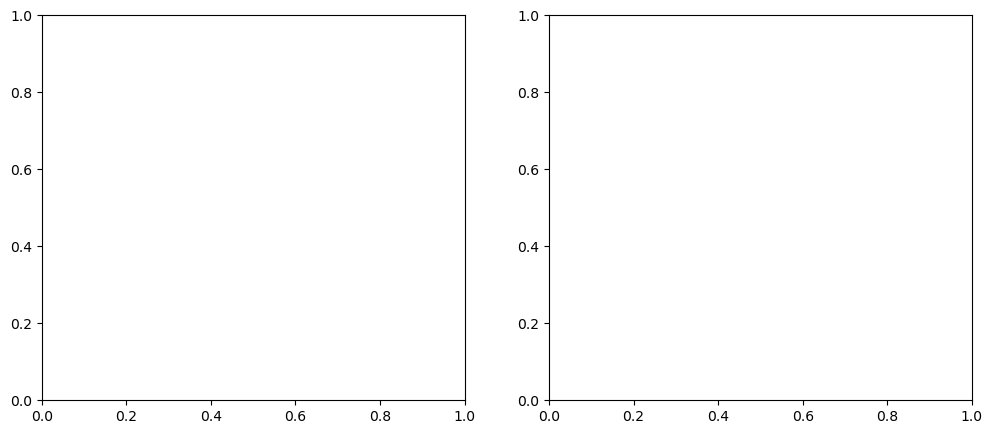

In [13]:
# 3️⃣ ACF & PACF Plot
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(series, ax=ax[0], lags=50)
plot_pacf(series, ax=ax[1], lags=50)
ax[0].set_title("Autocorrelation Function (ACF)")
ax[1].set_title("Partial Autocorrelation Function (PACF)")
plt.show()

In [12]:
# 4️⃣ Uji Stasioneritas - ADF Test
adf_test = adfuller(series)
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

if adf_test[1] < 0.05:
    print("✅ Data Stasioner (p-value < 0.05)")
else:
    print("❌ Data Tidak Stasioner (p-value > 0.05), perlu diferensiasi.")

# 5️⃣ Differencing (d=1) Jika Data Tidak Stasioner
if adf_test[1] > 0.05:
    df['Terakhir_diff'] = df['Terakhir'].diff()

    # Plot hasil differencing
    plt.figure(figsize=(12, 5))
    plt.plot(df['Terakhir_diff'], label="Differenced Stock Price", color='red')
    plt.title("Data Setelah Differencing (d=1)")
    plt.xlabel("Tanggal")
    plt.ylabel("Perubahan Harga Saham")
    plt.legend()
    plt.show()

    # Ulangi ADF Test Setelah Differencing
    adf_test_diff = adfuller(df['Terakhir_diff'].dropna())  # Drop NaN hasil differencing pertama
    print(f'ADF Statistic setelah differencing: {adf_test_diff[0]}')
    print(f'p-value setelah differencing: {adf_test_diff[1]}')

    if adf_test_diff[1] < 0.05:
        print("✅ Data Stasioner setelah differencing (p-value < 0.05), siap untuk model ARIMA/SARIMA.")
    else:
        print("❌ Data masih tidak stasioner, perlu differencing tambahan (d=2).")

NameError: name 'series' is not defined

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


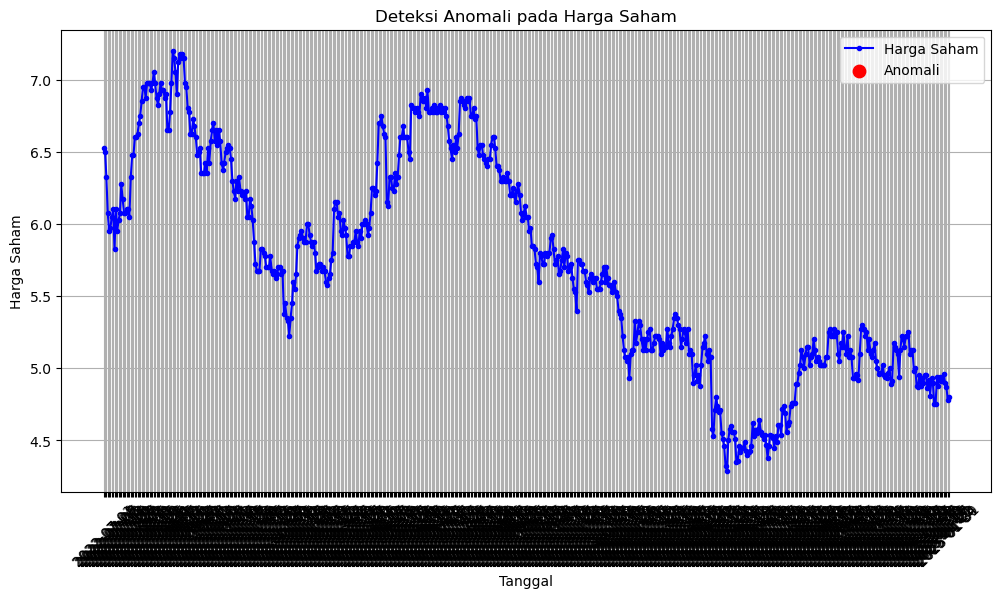

In [21]:
# Menggunakan metode IQR (Interquartile Range) untuk deteksi anomali
Q1 = df['Terakhir'].quantile(0.25)
Q3 = df['Terakhir'].quantile(0.75)
IQR = Q3 - Q1

# Menentukan batas bawah dan atas anomali
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Menandai data yang merupakan anomali
df['Anomaly'] = (df['Terakhir'] < lower_bound) | (df['Terakhir'] > upper_bound)

# Visualisasi data dengan anomali
plt.figure(figsize=(12, 6))
plt.plot(df['Tanggal'], df['Terakhir'], label='Harga Saham', color='blue', marker='o', markersize=3, linestyle='-')

# Menyoroti titik anomali
anomalies = df[df['Anomaly']]
plt.scatter(anomalies['Tanggal'], anomalies['Terakhir'], color='red', label='Anomali', marker='o', s=80)

# Label dan legend
plt.xlabel('Tanggal')
plt.ylabel('Harga Saham')
plt.title('Deteksi Anomali pada Harga Saham')
plt.legend()
plt.xticks(rotation=45)
plt.grid()

# Menampilkan plot
plt.show()

c:\Users\dylan\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 1200x500 with 0 Axes>

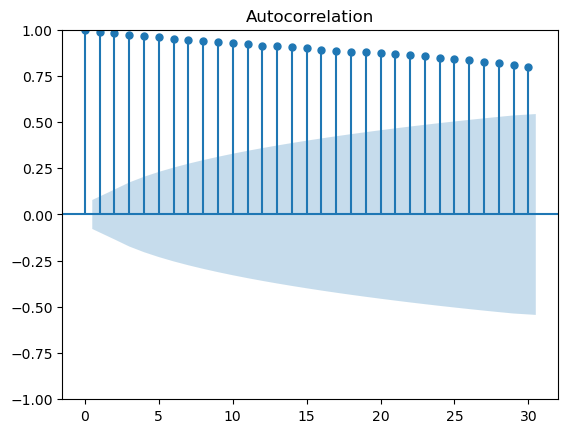

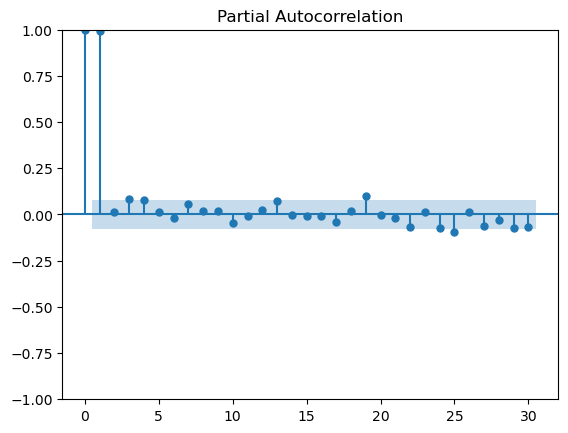

In [40]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 5))
plot_acf(df['Terakhir'], lags=30)
plot_pacf(df['Terakhir'], lags=30)
plt.show()


In [23]:
# Konversi tanggal agar tidak menyebabkan error
df = df.rename(columns={
    "Tanggal": "ds",
    "Terakhir": "y_last",
    "Pembukaan": "y_open",
    "Tertinggi": "y_high",
    "Terendah": "y_low"
})
df["ds"] = pd.to_datetime(df["ds"])  # Konversi string ke datetime

# DataFrame untuk menyimpan hasil prediksi
df_results = pd.DataFrame(columns=['ds', 'y_last', 'y_open', 'y_high', 'y_low'])


In [25]:
nixtla_client.plot(train_df_gaps)

NameError: name 'train_df_gaps' is not defined

In [ ]:
from nixtla import NixtlaClient

nixtla_client = NixtlaClient(api_key='nixak-8QsmYxQ9o5RhRrD06iOlKX3IjrxOJvVz4DWYCQ521BPwlxBBYAXA4CcHHamOcZ7acNwBw8GjU3xog02E')

timegpt_fcst_df = nixtla_client.forecast(
    df=df,
    h=1,
    freq='B',
    time_col='Tanggal',
    target_col='Terakhir'
)


In [ ]:
# Rentang tanggal prediksi
start_date = pd.to_datetime('2024-09-01')
end_date = pd.to_datetime('2025-01-31')

# Iterasi harian
current_date = start_date
while current_date <= end_date:
    # Ambil subset data hingga tanggal saat ini
    train_subset = df[df['ds'] < current_date].copy()

    # Prediksi untuk setiap harga
    forecast_last = nixtla_client.forecast(
        df=train_subset[['ds', 'y_last']],
        h=1, freq='D', time_col='ds', target_col='y_last',
        model='timegpt-1'
    )
    
    # Simpan hasil prediksi
    df_results = pd.concat([
        df_results,
        pd.DataFrame({
            'ds': [current_date],
            'y_last': [forecast_last['TimeGPT'][0]],
            'y_open': [forecast_open['TimeGPT'][0]],
            'y_high': [forecast_high['TimeGPT'][0]],
            'y_low': [forecast_low['TimeGPT'][0]],
        })
    ], ignore_index=True)

    # Update tanggal ke hari berikutnya
    current_date += pd.Timedelta(days=1)
    print(current_date, "Sukses!")

# **Export hasil ke CSV**
df_results.to_csv("forecast_results.csv", index=False)
print("Hasil prediksi telah disimpan dalam 'forecast_results.csv'")

INFO:nixtla.nixtla_client:Validating inputs...


ValueError: Series contain missing or duplicate timestamps, or the timestamps do not match the provided frequency.
Please make sure that all series have a single observation from the first to the last timestamp and that the provided frequency matches the timestamps'.
You can refer to https://docs.nixtla.io/docs/tutorials-missing_values for an end to end example.